#### Importación de datos de un archivo mat a Python
#### Script: matM9toPy.py

**Gabriel Ruiz Martinez**

[ORCID](https://orcid.org/0000-0001-6651-7836) | [Scopus](https://www.scopus.com/authid/detail.uri?authorId=57188985692) | [Posgrado IMTA](http://posgrado.imta.edu.mx/index.php/2-inicio/168-semblanza-curricular-dr-gabriel-ruiz-martinez)

Tecnólogo del Agua | Subcoordinación de Aguas Superficiales y Océanicas.

[Instituto Mexicano de Tecnología del Agua](https://www.gob.mx/imta).
Agosto del 2023



Cuando se utiliza el perfilador portatil Sontek Surveyor M9 para medir flujos de agua y batimetría en un río o embalse de de agua, el dispositivo electrónico exporta los valores registrados en un archivo mat. Este tipo de archivos requiere que se tenga Matlab para procesar los datos. Sin embargo, Matlab es un programa comercial que en algunas ocasiones no se tiene la licencia para realizar el postprocesamiento de los datos del M9; por tal razón, a continuación se presenta una metodología para importar los datos de un archivo mat a Python.


modificación: 04.

#### 1. Importando los módulos.

In [1]:
from collections import OrderedDict
import fiona
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio 
import simplekml
import math

#### 2. Definiendo funciones de usuario.

In [2]:
def points2layer(inputfile, shpfile, cs):
    '''
    Script que exporta PUNTOS de un archivo csv a un archivo shapefile,
    creandose los archivos .dbf, .prj, .shp y .shx.
    SE REQUIEREN LOS MODULOS DE FIONA Y PANDAS. El archivo csv que se usara para         
    generar la tabla de atributos debera tener 1 linea de encabezados y 3 
    columnas, en el siguiente orden y nombre del encabezado:
    1. coordenadas de longitud (Lon), 
    2. coordenadas de latitud (Lat), 
    3. etiqueta del punto (Etiqueta).
    Argumentos de la funcion:
    inputfile: nombre del archivo csv con los puntos,
               incluir la extension del archivo.
    shpfile: nombre del shapefile (este nombre se 
             exportara como el nombre de la capa)
             no incluir la extension de archivo.
    cs = Sistema de referencia geografico de los puntos.
             
    Ejemplo:
        inputfile = 'PtosPista.csv'
        shpfile = 'PuntosPista'
        cs = 'WGS84'

        points2layer(inputfile,shpfile,cs)
    Gabriel Ruiz, 2022. IMTA.
    '''
    
    try:
        # Abriendo el archivo de datos y guardando en un dataframe de Pandas
        if inputfile[-1] == 'z':   # xyz
            datos = pd.read_csv(inputfile, header = 0, sep = ' ')
            datacsv = 0;
            schema = {
                'geometry': 'Point',
                'properties': OrderedDict([
                    ('ID', 'int'),
                    ('Nombre', 'str'),
                    ('X/Lon', 'float'),
                    ('Y/Lat', 'float'),
                    ('Z', 'float'),
                    ('Cuerpo', 'str')
                    ])
                }            
        else:                      # cvs
            datos = pd.read_csv(inputfile, header = 0, sep = ',')
            datacsv = 1;
            
            # Definiendo el esquema que requiere fiona para la 
            # exportación de la tabla de atributos
            schema = {
                'geometry': 'Point',
                'properties': OrderedDict([
                    ('ID', 'int'),
                    ('Nombre', 'str'),
                    ('X/Lon', 'float'),
                    ('Y/Lat', 'float')
                    ])
                }

        # Estableciendo el sistema de referencia
        if cs == 'WGS84':
                sc = 'EPSG:4326'
        elif cs == 'UTM_13N':
                sc = 'EPSG:32613'
        elif cs == 'UTM_14N':
                sc = 'EPSG:32614'
        elif cs == 'UTM_15N':
                sc = 'EPSG:32615'
        elif cs == 'UTM_16N':
                sc = 'EPSG:32616'
              
        # Almacenando en tupla el no. de filas y columnas del dataframe
        nf = datos.shape

        # Creando la coleccion que se usara para exportar los datos
        pto2shp = fiona.open(shpfile+'.shp', 
                             mode = 'w', 
                             driver = 'ESRI Shapefile', 
                             schema = schema, 
                             crs = sc)
        
        # Exportando los datos, via diccionario, a la coleccion de fiona
        if datacsv == 1:
            for i in range(nf[0]):
                dicdatos = {
                    'geometry': {'type': 'Point', 
                                 'coordinates': (datos.Lon[i],datos.Lat[i])},
                    'properties':{'ID': i, 
                                  'Nombre': datos.Etiqueta[i],
                                  'X/Lon': datos.Lon[i],
                                  'Y/Lat': datos.Lat[i]} }
                pto2shp.write(dicdatos)
        else:
            for i in range(nf[0]):
                
                if datos.iloc[i,2] < 0:
                    cuerpo = 'Tierra'
                else:
                    cuerpo = 'Agua'
                    
                dicdatos = {
                    'geometry': {'type': 'Point', 
                                 'coordinates': (datos.iloc[i,0],datos.iloc[i,1])},
                    'properties':{'ID': i, 
                                  'Nombre': 'Punto' + str(i),
                                  'X/Lon': datos.iloc[i,0],
                                  'Y/Lat': datos.iloc[i,1],
                                  'Z': datos.iloc[i,2],
                                  'Cuerpo': cuerpo
                                  } }
                pto2shp.write(dicdatos)

        # Cerrando la coleccion fiona (cerrando archivos creados)
        pto2shp.close()
        print('Los puntos se han enviado a un archivo SHP.')
    except:
        print('Error en la funcion')  
    return 

#### 3. Metodología (Script).

Para importar los datos que se encuentran almacenados en el archivo mat, vamos a usar el método `loadmat` del modulo Scipy. Este método importa los datos hacia un diccionario. Cada variable que se encuentra en el archivo mat, le corresponde un clave y valor en el diccionario. <br> 

Los nombres de las claves corresponden a los nombres de las estructuras de Matlab. A continuación, vamos a importar los datos de un archivo mat a la variable `datos`. Cabe resaltar que este archivo mat fue creado a partir del post-proceso que se realizó a un archivo riv del dispositivo Sontek Surveyor M9, usado para obtener la batimetría de un cuerpo de agua.

In [3]:
nfile = '20230719091839'
datos = sio.loadmat(nfile, appendmat=True)

Vamos a revisar las etiquetas del diccionario con los datos importados.

In [4]:
sorted(datos.keys())

['BottomTrack',
 'Compass',
 'GPS',
 'Processing',
 'RawGPSData',
 'Setup',
 'SiteInfo',
 'Summary',
 'System',
 'SystemHW',
 'Transformation_Matrices',
 'WaterTrack',
 '__globals__',
 '__header__',
 '__version__']

Para este ejemplo, los datos que nos interesan se encuentran en las etiquetas <i>BottomTrack</i> y <i>GPS</i>. Extraígamos los datos que se encuentran en BottomTrack y vamos a almacenarlos en la variable `databBT`.

In [5]:
dataBT = datos['BottomTrack']

Vamos a identificar el tipo de datos que contiene la variable `dataBT`:

In [6]:
dataBT.dtype

dtype([('VB_Depth', 'O'), ('BT_Depth', 'O'), ('BT_Vel', 'O'), ('BT_Beam_Depth', 'O'), ('BT_Frequency', 'O'), ('Units', 'O')])

Podemos identificar que Scipy lee las estructuras de Matlab como <b>arreglos estructurados de Numpy</b> (<i>ndarray object of Numpy module</i>) y el tipo de dato será "objeto"  (<i>'O'</i> ). También, podemos observar que la estructura BottomTrack, contiene 6 subestructuras donde se encuentran los datos registrados por el dispositivo electrónico M9. Vamos a extraer los datos de las profundidades (valor z) y almacenarlos en sus respectivas variables:

In [7]:
dBT = datos["BottomTrack"]["BT_Depth"]

A continuación, verífiquemos el tamaño y el número de elementos que tienen las variables con los datos de interés.

In [8]:
dBT.size

1

In [9]:
dBT.shape

(1, 1)

El tamaño del arreglo estructurado es igual al tamaño de la estructura de Matlab, pero por default, Scipy proporciona una objeto bidimensional. Para comprender que ocurre con el tamaño y número de datos, vamos a revisar el contenido de la variable:

In [10]:
dBT

array([[array([[0.41599999],
               [0.415     ],
               [0.43399999],
               ...,
               [0.71400002],
               [0.70900003],
               [0.70500002]])]], dtype=object)

Observa que el número de datos almacenados es uno (obtenido con `dBT.size`), pero el objeto tiene dos dimensiones (conocido a partir de `dBT.shape`). Para tener objetos unidimensionales es necesario agregar el parámetro `squeeze_me=True` en el método `loadmat`. 

Vamos a borrar todas las variables que hemos generado para volver a cargar los datos, pero ahora vamos a obtener arreglos estructurados de una dimensión:

In [11]:
del datos, dataBT, dBT

In [12]:
datos = sio.loadmat('20230719091839', appendmat=True, squeeze_me=True)
dBT = datos["BottomTrack"]["BT_Depth"]

Vamos a revisar el tamaño, dimensión, tipo de dato y los valores de la variable `dBT`:

In [13]:
dBT.size


1

In [14]:
dBT.shape

()

In [15]:
dBT.dtype

dtype('O')

In [16]:
dBT

array(array([0.41599999, 0.415     , 0.43399999, ..., 0.71400002, 0.70900003,
       0.70500002]), dtype=object)

Podemos identificar que `dBT` tiene una dimensión cero, por ello, Python maneja el arreglo como unidimensional. Para mayor detalle, consulta la sección de <i>Calculation</i> en https://numpy.org/doc/stable/reference/arrays.ndarray.html<br>

También se identifica que el tipo de dato continua siendo un objeto. A continuación, vamos a convertir el arreglo "objeto" a un arreglo numérico. Para ello, vamos a realizar una copia del arreglo y lo colapsaremos a un arreglo de una dimensión:

In [17]:
dBT1d = dBT.flatten()

Revisamos la dimensión del nuevo arreglo:

In [18]:
dBT1d.shape

(1,)

In [19]:
dBT1d

array([array([0.41599999, 0.415     , 0.43399999, ..., 0.71400002, 0.70900003,
              0.70500002])                                                    ],
      dtype=object)

Vamos a poner el arreglo de manera vertical ("arreglo columna"), después visualizamos el arreglo, así como el tipo de dato que tiene dicho arreglo:

In [20]:
dBT1d = np.vstack(dBT1d)
print(dBT1d)
print('Tipo de dato:', dBT1d.dtype)

[[0.41599999 0.415      0.43399999 ... 0.71400002 0.70900003 0.70500002]]
Tipo de dato: float64


Para finalizar vamos a crear un arreglo "fila", con el número de datos que tiene el arreglo:

In [21]:
del dBT
dBT = dBT1d.reshape(dBT1d.size)

El  arreglo, tamaño, tipo de dato y dimensión son:

In [22]:
dBT

array([0.41599999, 0.415     , 0.43399999, ..., 0.71400002, 0.70900003,
       0.70500002])

In [23]:
print(dBT.size, 'datos')
print(dBT.shape)
print('Tipos de datos:', dBT.dtype)
print('Tipo de variable:', type(dBT))

4321 datos
(4321,)
Tipos de datos: float64
Tipo de variable: <class 'numpy.ndarray'>


Vamos a importar los datos registrados por el sensor vertical de profundidad del M9:

In [24]:
dvb = datos["BottomTrack"]["VB_Depth"]
dVb = np.vstack(dvb.flatten())
dVB = dVb.reshape(dVb.size)
del dvb, dVb

También, vamos a extraer las coordenadas geográficas de los puntos muestreados (coordenadas espaciales x y y, o latitud y longitud) y almacenarlos en sus respectivas variables. Las coordenadas se encuentran en la etiqueta GPS y en las subestructuras 'UTM', 'longitude' y 'latitude'.

In [25]:
longi = datos["GPS"]["Longitude"]
longit = np.vstack(longi.flatten())
lon = longit.reshape(longit.size)
del longi, longit

latid = datos["GPS"]["Latitude"]
lati = np.vstack(latid.flatten())
lat = lati.reshape(lati.size)
del latid, lati

utmd = datos["GPS"]["UTM"]
utm1 = np.stack(utmd.flatten())
utm = utm1.reshape(utm1.size)
del utmd, utm1

En el caso de las coordenadas UTM, los datos se encontraban en un arreglo con dos columnas, pero al momento de convertir el arreglo estructurado (objeto) a un arreglo de una columna por n líneas, el arreglo que obtuvimos fue unidimensional, por tal razón, es necesario "filtrar" las coordenadas x y y de dicho arreglo para separar los valores de x y y.

In [26]:
yind = np.where(utm > 1000000)
y = utm[yind]
xind = np.where(utm < 600000)
x = utm[xind]
del yind, xind

num_datos = lon.size

A manera de revisión de los valores de la profundidad, vamos a identificar que no existan registros de la profundidad del Bottom Tracking que sean cero. Para ello, localizar los indices de los registros donde existe un cero, utilizaremos la función `np.where`; esta función nos dará como resultado un tupla y con los valores de los indices que cumplen la condicional que hemos impuesto. Recuerda que en los registros, la profundidad es positiva, es decir, valores batimétricos positivos y valores topográficos, son negativos.

In [27]:
dat_zero = np.where(dBT <= 0)

Vamos a desplegar un aviso de advertencia que indique cuando los datos contienen ceros. Si este caso se presenta entonces, usando los indices, eliminaremos todos los registros con valores de cero o topográficos.

Teniendo los indices de los registros con los valores que no deseamos considerar, a continuación vamos a hacer un arreglo que contenga los valores de los indices de nuestro arreglo a depurar (usando `np.arange`). Para eliminar los registros, crearemos una máscara con la función `np.isin`; esta función generar una máscara booleana donde se identifican los elementos que deseamos ubicar en un arreglo.

In [28]:
print('El archivo {}.mat contiene {} registros.'.format(nfile, num_datos))
if dat_zero[0].size > 0:
    print('Sin embargo:')
    print('El archivo contiene {} registros con ceros en la profundidad,'.format(dat_zero[0].size))
    print('estos registros no serán exportados!')
    element = np.arange(num_datos)
    lon = lon[~np.isin(element, dat_zero)]
    lat = lat[~np.isin(element, dat_zero)]
    x = x[~np.isin(element, dat_zero)]
    y = y[~np.isin(element, dat_zero)]
    dBT = dBT[~np.isin(element, dat_zero)]
    dVB = dVB[~np.isin(element, dat_zero)]
    print('Despues del filtrado se tienen {} registros.\n'.format(dBT.size))

El archivo 20230719091839.mat contiene 4321 registros.
Sin embargo:
El archivo contiene 8 registros con ceros en la profundidad,
estos registros no serán exportados!
Despues del filtrado se tienen 4313 registros.



Para tener una idea de los datos que estamos manejando, visualizamos la siguiente información que se encuentra relacionada a los datos que estamos usando:

Información:
Profundidad min:    0.274 m
Profundidad max:    2.689 m
Registros con profundidad de 0 m a 1 m: 3345
Registros con profundidad de 1 m a 2 m: 834
Registros con profundidad de 2 m a 3 m: 134



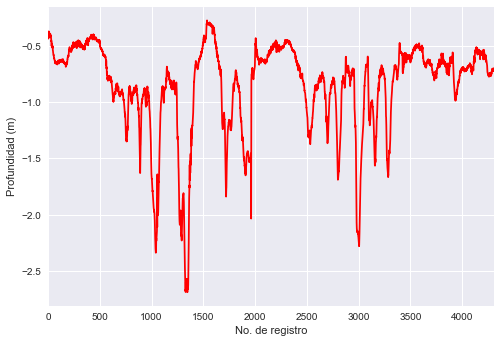

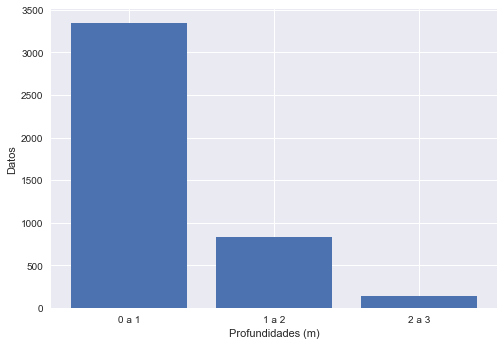

In [29]:
print('Información:')
print('Profundidad min: {:8.3f} m'.format(np.min(dBT)))
print('Profundidad max: {:8.3f} m'.format(np.max(dBT)))
z_range = np.arange(0, np.ceil(np.max(dBT)), 1, dtype=int)
n_depths = np.zeros(z_range.size)
etiq = []

for i in range(z_range.size):
    if i < z_range.size-1:
        temp = np.logical_and((dBT >= z_range[i]), (dBT < z_range[i+1]))
        n_depths[i] = np.extract(temp, dBT).size
        print('Registros con profundidad de {} m a {} m: {}'.format(z_range[i], z_range[i+1], int(n_depths[i])))
        etiq.append(str(z_range[i])+' a '+ str(z_range[i+1]))
    else:
        temp = np.where(dBT > z_range[i])
        n_depths[i] = temp[0].size
        print('Registros con profundidad de {} m a {} m: {}\n'.format(z_range[i], z_range[i]+1, int(n_depths[i])))
        etiq.append(str(z_range[i])+' a '+ str(z_range[i]+1))

plt.style.use('seaborn')
plt.figure()
plt.plot(-dBT, color='r')
plt.xlabel('No. de registro')
plt.ylabel('Profundidad (m)')
plt.xlim([0, dBT.size])
plt.savefig(fname=nfile+'_Rec.png', dpi='figure', format='png')

plt.figure()
plt.bar(etiq, n_depths)
plt.xlabel('Profundidades (m)')
plt.ylabel('Datos')
plt.savefig(fname=nfile+'_Bar.png', dpi='figure', format='png')

A manera de respaldo, vamos a exportar todos los datos que fueron importados del archivo mat a un archivo del tipo csv, que puede abrirse con un programa de hoja de cálculo electrónico o un programa que permita abrir archivos de texto plano. La exportación se realizará con el módulo Pandas. 

Por tal razón, vamos almacenar todos los arreglos que nos interesan en un DataFrame de Pandas:

In [30]:
dataGEO = pd.DataFrame({'lon(°)':lon, 'lat(°)':lat, 'x(m)':x, 'y(m)':y, 'BT(m)':dBT, 'VB(m)':dVB})
dataUTM = pd.DataFrame({'x(m)':x, 'y(m)':y, 'BT(m)':dBT, 'VB(m)':dVB})

In [31]:
print('Revisando el orden de los datos que seran exportados:')
# Se muestran solo el inicio y final de los datos
print(dataGEO.head())
print('.\n.\n.\n')
print(dataGEO.tail())
print('')
print(dataUTM.head())
print('.\n.\n.\n')
print(dataUTM.tail())
print('')

Revisando el orden de los datos que seran exportados:
      lon(°)     lat(°)           x(m)          y(m)  BT(m)  VB(m)
0 -92.847107  15.203079  516421.539201  1.680793e+06  0.416  0.412
1 -92.847107  15.203079  516421.539201  1.680793e+06  0.415  0.437
2 -92.847107  15.203079  516421.539201  1.680793e+06  0.434  0.435
3 -92.847107  15.203079  516421.539201  1.680793e+06  0.436  0.000
4 -92.847107  15.203079  516421.539201  1.680793e+06  0.419  0.000
.
.
.

         lon(°)     lat(°)           x(m)          y(m)  BT(m)  VB(m)
4308 -92.848697  15.202461  516250.850033  1.680725e+06  0.698  0.698
4309 -92.848704  15.202469  516250.027033  1.680726e+06  0.703  0.697
4310 -92.848712  15.202476  516249.168033  1.680727e+06  0.714  0.720
4311 -92.848721  15.202484  516248.272033  1.680727e+06  0.709  0.711
4312 -92.848729  15.202491  516247.332033  1.680728e+06  0.705  0.710

            x(m)          y(m)  BT(m)  VB(m)
0  516421.539201  1.680793e+06  0.416  0.412
1  516421.539201  1.680793

A continuación, vamos a exportar los DataFrames hacia archivos csv:

In [32]:
dataGEO.to_csv(nfile+'_GEO.csv', header=True, index=False)
dataUTM.to_csv(nfile+'_UTM.csv', header=True, index=False)

Con las siguientes líneas de código se va a generar un shapefile, que podemos usar para visualizar los puntos en cualquier software GIS. 

In [33]:
del datos
# Creando el arreglo para las etiquetas de los puntos (ver el comentario de la función points2layer)
eti = []
for i in range(lon.size):
    eti.append('P' + str(i+1))
    
# Creando el DataFrame con la ubicacion de los puntos
dataGEO2 = pd.DataFrame({'Lon':lon, 'Lat':lat, 'Etiqueta':eti})
print(dataGEO2.head())
print('.\n.\n.\n')
print(dataGEO2.tail())
print('')

# Generando el archivo CSV con las coordenadas de los puntos
dataGEO2.to_csv(nfile + '_GEO2.csv', header=True, index=False)

# Creando el archivo shapefile
points2layer(nfile + '_GEO2.csv', nfile + '_GEOPoints', 'WGS84')

         Lon        Lat Etiqueta
0 -92.847107  15.203079       P1
1 -92.847107  15.203079       P2
2 -92.847107  15.203079       P3
3 -92.847107  15.203079       P4
4 -92.847107  15.203079       P5
.
.
.

            Lon        Lat Etiqueta
4308 -92.848697  15.202461    P4309
4309 -92.848704  15.202469    P4310
4310 -92.848712  15.202476    P4311
4311 -92.848721  15.202484    P4312
4312 -92.848729  15.202491    P4313

Los puntos se han enviado a un archivo SHP.


Por otra parte, puede existir el caso donde no es posible usar algún software de GIS para visualizar la ubicación de los puntos batimétricos; por tal razón, vamos a exportar las coordenadas geográficas de los puntos de la batimetría a un archivo kml para identificar el área de interés en Google Earth.

In [34]:
# Abriendo la instancia kml
kml = simplekml.Kml()

for i in range(dataGEO2.shape[0]):
    pto = kml.newpoint()
    pto.name = dataGEO2['Etiqueta'][i]
    pto.coords =[(dataGEO2['Lon'][i], dataGEO2['Lat'][i])]

# Exportando la instancia kml a un archivo
kml.save(nfile+'.kml')
print('Los puntos se han enviado a un archivo kml')

Los puntos se han enviado a un archivo kml


Usando las coordenadas espaciales, vamos a determinar los límites del área de interés:

In [35]:
# Coordenadas geograficas
lomin = dataGEO["lon(°)"].min()
lomax = dataGEO["lon(°)"].max()

lamin = dataGEO["lat(°)"].min()
lamax = dataGEO["lat(°)"].max()

# Coordenadas UTM
xmin = dataUTM["x(m)"].min()
xmax = dataUTM["x(m)"].max()

ymin = dataUTM["y(m)"].min()
ymax = dataUTM["y(m)"].max()

Nuestra área de interés se encuentra delimitada por los siguientes vértices:

In [36]:
# En coordenadas geográficas
print('\nBordes del area de interes, en coordenadas geograficas:')
print('Esquina Inferior Izquierda: {}, {}'.format(lomax, lamin))
print('Esquina Inferior Derecha: {}, {}'.format(lomin, lamin))
print('Esquina Superior Izquierda: {}, {}'.format(lomax, lamax))
print('Esquina Superior Derecha: {}, {}'.format(lomin, lamax))


Bordes del area de interes, en coordenadas geograficas:
Esquina Inferior Izquierda: -92.84574730157526, 15.198456381764666
Esquina Inferior Derecha: -92.85382247726409, 15.198456381764666
Esquina Superior Izquierda: -92.84574730157526, 15.204652475473823
Esquina Superior Derecha: -92.85382247726409, 15.204652475473823


Calculemos la distancia total de 2 de los vértices:

In [37]:
llon = lomax - lomin
llat = lamax - lamin

lx = xmax - xmin
ly = ymax - ymin

In [38]:
print('\nDimensiones del area muestreada:')
print('Distancia horizontal: {}° ó {:8.3f} m'.format(llon, lx))
print('Distancia vertical: {}° ó {:8.3f} m'.format(llat, ly))


Dimensiones del area muestreada:
Distancia horizontal: 0.008075175688830427° ó  867.636 m
Distancia vertical: 0.006196093709156969° ó  685.122 m
